In [144]:
import json
import hashlib
import pandas as pd
import unicodedata
import re
from datetime import datetime

teams_json = "teams.json"
elos_json = "elos.json"
data = pd.read_csv('La-Liga_2023-2024.csv')
data = pd.read_csv('combined.csv').iloc[:, 1:]
data = data[data['Date']>'2022-01-01'].dropna()
data

,Season,Wk,Date,Home,Away,Home_Goals,Away_Goals,Result
12886,2021-2022,19,2022-01-02,Getafe,Real Madrid,1.0,0.0,1.0
12887,2021-2022,19,2022-01-02,Atlético Madrid,Rayo Vallecano,2.0,0.0,1.0
12888,2021-2022,19,2022-01-02,Elche,Granada,0.0,0.0,0.5
12889,2021-2022,19,2022-01-02,Alavés,Real Sociedad,1.0,1.0,0.5
12890,2021-2022,19,2022-01-02,Betis,Celta Vigo,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...
28304,2024-2025,24,2025-02-16,Valladolid,Sevilla,0.0,4.0,0.0
28305,2024-2025,24,2025-02-16,Mallorca,Las Palmas,3.0,1.0,1.0
28306,2024-2025,24,2025-02-16,Betis,Real Sociedad,3.0,0.0,1.0
28307,2024-2025,24,2025-02-17,Barcelona,Rayo Vallecano,1.0,0.0,1.0


In [135]:
# --- ADD TEAM ---

def add_team(new_team):

    with open(teams_json, "r") as file:
            teams = json.load(file)
    
    if any(team["team_id"] == new_team["team_id"] for team in teams):
        return

    teams.append(new_team)
    
    with open(teams_json, "w") as file:
        json.dump(teams, file, indent=4)

# --- UPDATE ELOS ---

def update_elo(new_team):
    elos_data = load_json(elos_json)  # Load existing ELO data

    existing_ids = {team["elo_id"] for team in elos_data}  # Use set for fast lookup
    if new_team["elo_id"] not in existing_ids:
        elos_data.append(new_team)  # Append only if new elo_id is unique
        save_json(elos_json, elos_data)

# --- UNIQUE ID ---

def unique_id(string):
    match_id = hashlib.sha256(string.encode()).hexdigest()[:10]
    return match_id

# --- NORMALIZE STRING ---

def normalize_string(s):

    s = s.lower()
    s = unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("utf-8")
    s = re.sub(r"[^a-z0-9\s]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    
    return s

# --- LOAD JSON ---
def load_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)
    
# --- SAVE JSON ---
def save_json(file_path, data):
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)
    
# --- GET LATEST ELO ---
def get_latest_elo(team_id):
    records = load_json(elos_json)
    team_records = [r for r in records if r["team_id"] == team_id]
    
    if not team_records:
        return 1500  # Default ELO if team_id is not found

    team_records.sort(key=lambda x: datetime.strptime(x["date"], "%Y-%m-%d"), reverse=True)
    return team_records[0]["elo"]

# --- ELO CALCULATION FUNCTION ---
def calculate_elo(home_elo, away_elo, result, k=40):
    expected_home = 1 / (1 + 10 ** ((away_elo - home_elo) / 400))
    expected_away = 1 - expected_home

    if result == 1:
        actual_home, actual_away = 1, 0
    elif result == 0:
        actual_home, actual_away = 0, 1
    else:
        actual_home, actual_away = 0.5, 0.5

    new_home_elo = home_elo + k * (actual_home - expected_home)
    new_away_elo = away_elo + k * (actual_away - expected_away)

    return round(new_home_elo), round(new_away_elo)

# --- PROCESS DATAFRAME ---
def process_dataframe(data):
    competition = "La-Liga"
    competition_id = unique_id(competition)

    # Load existing ELO data
    elos_data = load_json(elos_json)

    for index, row in data.iterrows():
        home_team_id = unique_id(normalize_string(row["Home"]))
        away_team_id = unique_id(normalize_string(row["Away"]))

        home_elo = get_latest_elo(home_team_id)
        away_elo = get_latest_elo(away_team_id)

        # Store the initial ELOs in the dataframe
        data.at[index, "home_elo"] = home_elo
        data.at[index, "away_elo"] = away_elo

        # Compute new ELOs
        new_home_elo, new_away_elo = calculate_elo(
            home_elo, away_elo, row['Result']
        )

        # Generate match_id
        match_id = unique_id(f"{row['Season']}{row['Date']}{row['Home']}{row['Away']}")

        # Create ELO updates for both teams
        home_elo_entry = {
            "team_id": home_team_id,
            "competition_id": competition_id,
            "match_id": match_id,
            "date": row["Date"],
            "elo": new_home_elo,
        }

        away_elo_entry = {
            "team_id": away_team_id,
            "competition_id": competition_id,
            "match_id": match_id,
            "date": row["Date"],
            "elo": new_away_elo,
        }

        # Append new ELOs without deleting previous matches
        elos_data.append(home_elo_entry)
        elos_data.append(away_elo_entry)
    
    # Save the updated ELOs
    save_json(elos_json, elos_data)
    return data

In [136]:
country = 'Spain'

for team in data['Home']:

    team = normalize_string(team)

    add_team( {
        "team_id": unique_id(team),
        "team_name": team,
        "country_id": unique_id(country)
    } )

In [145]:
for index, i in data.iterrows():
    uniques = [unique_id(normalize_string(i['Home'])), unique_id(normalize_string(i['Away']))]
    latests = [get_latest_elo(uniques[0]), get_latest_elo(uniques[1])]
    home_new, away_new = calculate_elo(latests[0], latests[1], i['Result'])
    news = [home_new, away_new]

    competition_id = unique_id(normalize_string('La-Liga'))
    match_id = unique_id(f'{i['Season']}{i['Date']}{i['Home']}{i['Away']}')
    date = i['Date']

    for x in range(2):
        update_elo({
            "elo_id": unique_id(f'{uniques[x]}{match_id}'),
            "team_id": uniques[x],
            "competition_id": competition_id,
            "match_id": match_id,
            "date": date,
            "elo": news[x]
        }
        )

    data.loc[index, 'home_elo'] = latests[0]
    data.loc[index, 'away_elo'] = latests[1]

In [146]:
data

,Season,Wk,Date,Home,Away,Home_Goals,Away_Goals,Result,home_elo,away_elo
12886,2021-2022,19,2022-01-02,Getafe,Real Madrid,1.0,0.0,1.0,1500.0,1500.0
12887,2021-2022,19,2022-01-02,Atlético Madrid,Rayo Vallecano,2.0,0.0,1.0,1500.0,1500.0
12888,2021-2022,19,2022-01-02,Elche,Granada,0.0,0.0,0.5,1500.0,1500.0
12889,2021-2022,19,2022-01-02,Alavés,Real Sociedad,1.0,1.0,0.5,1500.0,1500.0
12890,2021-2022,19,2022-01-02,Betis,Celta Vigo,0.0,2.0,0.0,1500.0,1500.0
...,...,...,...,...,...,...,...,...,...,...
28304,2024-2025,24,2025-02-16,Valladolid,Sevilla,0.0,4.0,0.0,1338.0,1500.0
28305,2024-2025,24,2025-02-16,Mallorca,Las Palmas,3.0,1.0,1.0,1500.0,1411.0
28306,2024-2025,24,2025-02-16,Betis,Real Sociedad,3.0,0.0,1.0,1520.0,1493.0
28307,2024-2025,24,2025-02-17,Barcelona,Rayo Vallecano,1.0,0.0,1.0,1691.0,1529.0


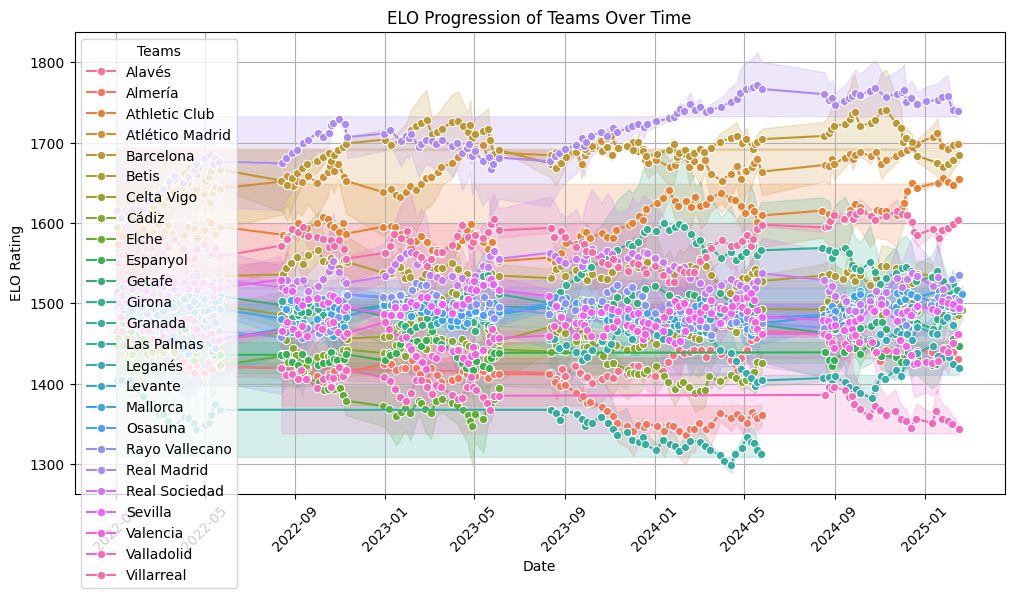

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new DataFrame combining Home & Away ELOs into one timeline per team
elo_data = pd.concat([
    data[['Date', 'Home', 'home_elo']].rename(columns={'Home': 'Team', 'home_elo': 'ELO'}),
    data[['Date', 'Away', 'away_elo']].rename(columns={'Away': 'Team', 'away_elo': 'ELO'})
])

# Sort by Date for better visualization
elo_data = elo_data.sort_values(by=['Team', 'Date'])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=elo_data, x='Date', y='ELO', hue='Team', marker='o')

# Formatting
plt.title('ELO Progression of Teams Over Time')
plt.xlabel('Date')
plt.ylabel('ELO Rating')
plt.legend(title='Teams')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


In [148]:
for i in load_json(teams_json):
    print(get_latest_elo(i['team_id']), i['team_name'])

1373 almeria
1500 sevilla
1493 real sociedad
1411 las palmas
1649 athletic club
1503 celta vigo
1600 villarreal
1519 getafe
1413 cadiz
1693 atletico madrid
1500 mallorca
1466 valencia
1501 osasuna
1506 girona
1691 barcelona
1520 betis
1432 alaves
1309 granada
1529 rayo vallecano
1733 real madrid
1500 oviedo
1500 logrones
1500 zaragoza
1500 real betis
1500 real murcia
1338 valladolid
1452 espanyol
1500 malaga
1500 sporting gijon
1397 elche
1500 castellon
1500 tenerife
1500 real burgos
1500 dep la coruna
1500 albacete
1500 racing sant
1500 lleida
1500 compostela
1500 merida
1500 salamanca
1500 hercules
1500 extremadura
1500 la coruna
1500 numancia
1500 recreativo
1512 levante
1500 gimnastic
1500 xerez
1500 eibar
1500 cordoba
1460 leganes
1500 huesca
